Procesando con ventana (3, 3)...
Procesamiento con ventana (3, 3) completado.
Procesando con ventana (15, 15)...
Procesamiento con ventana (15, 15) completado.
Procesando con ventana (51, 51)...
Procesamiento con ventana (51, 51) completado.


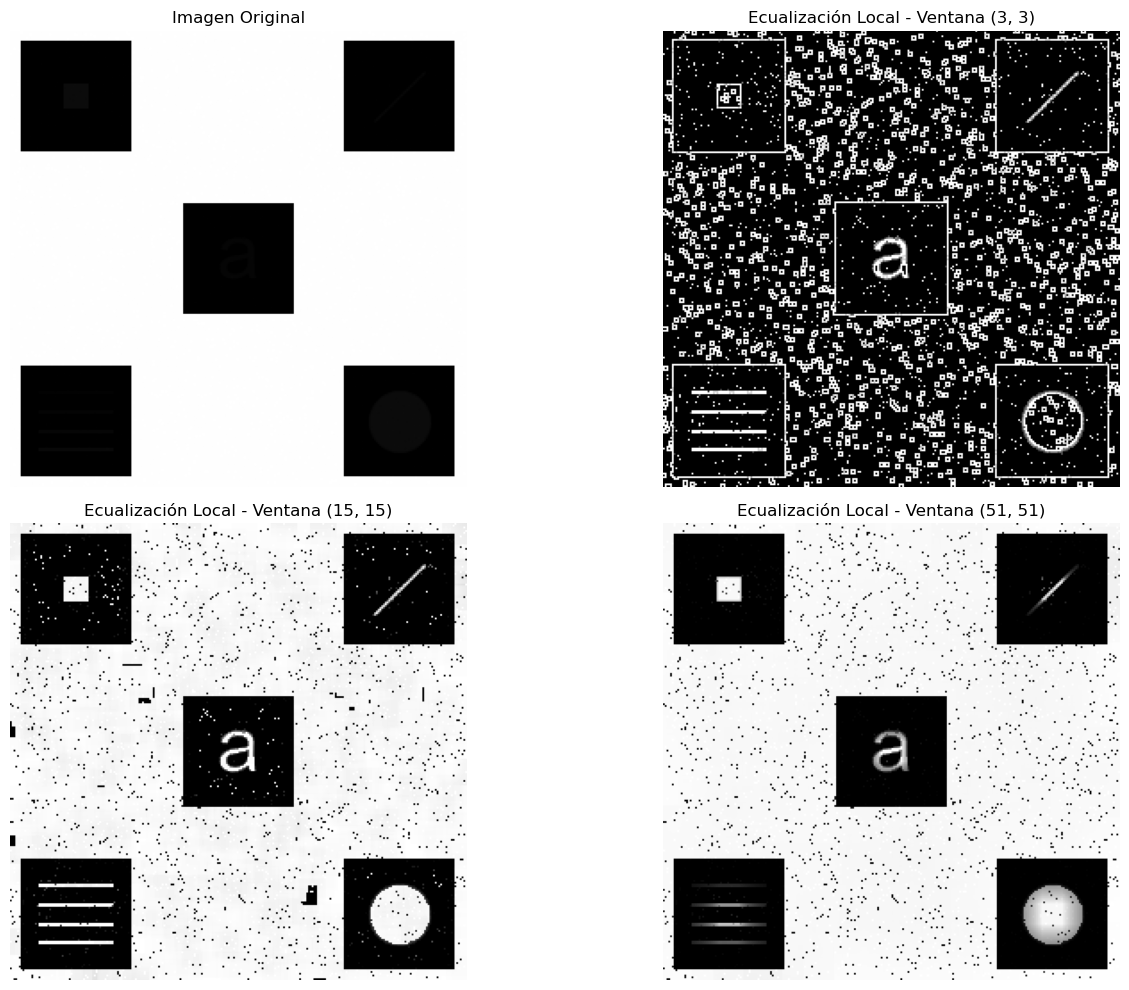

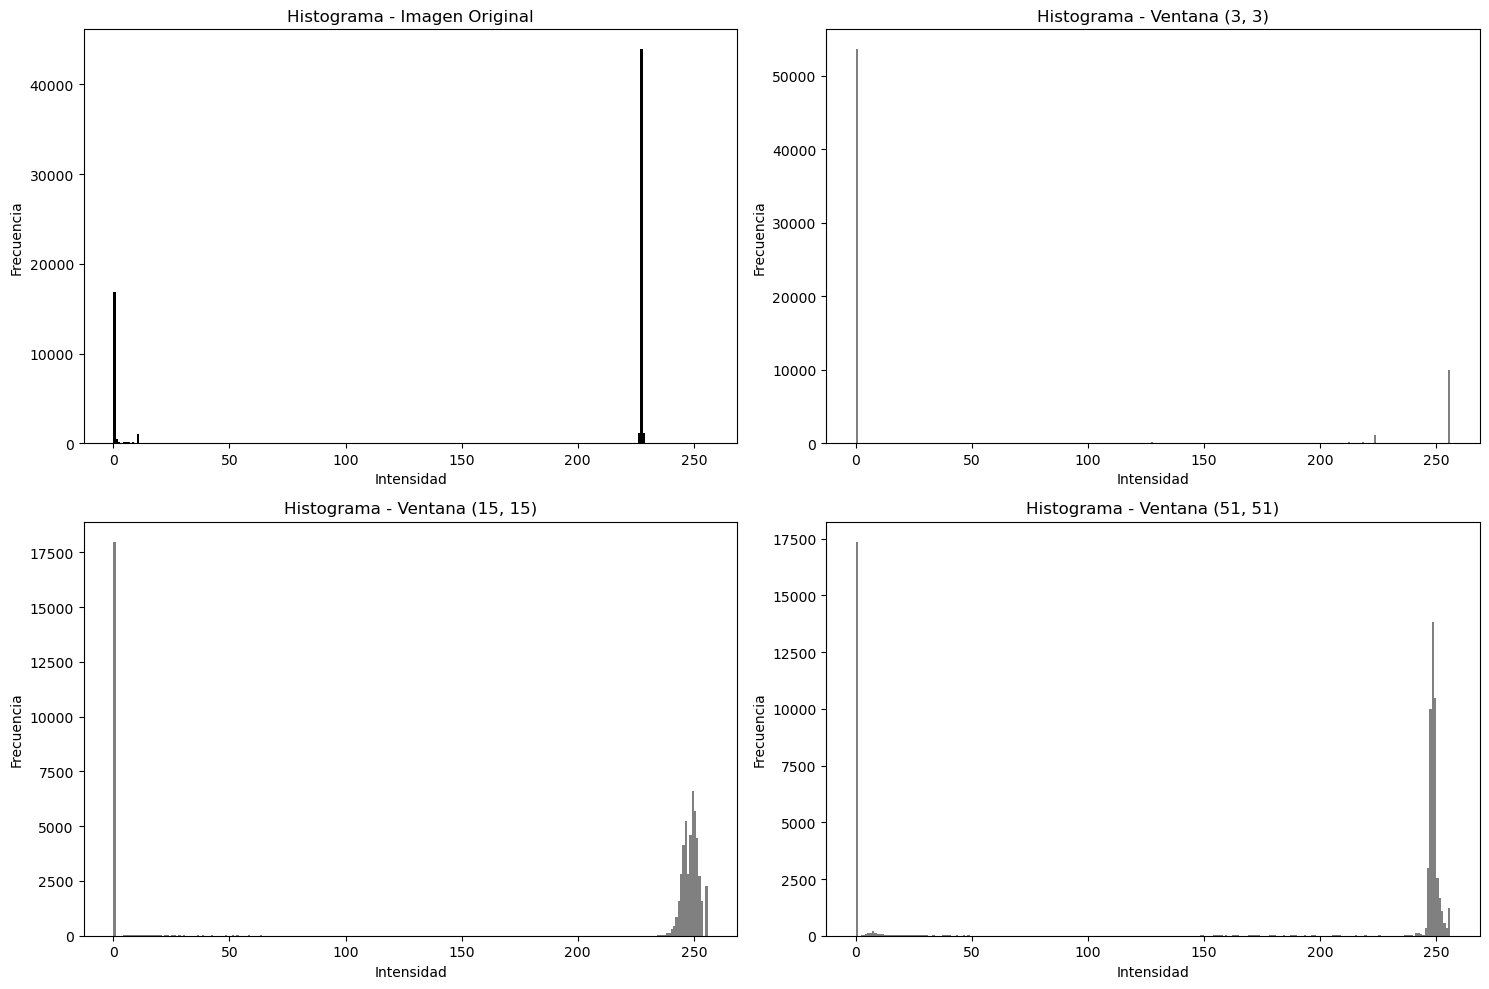

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def local_histogram_equalization(image, window_size):
    """
    Realiza la ecualización local del histograma en una imagen.

    Args:
        image (np.ndarray): Imagen de entrada (se convertirá a escala de grises).
        window_size (tuple): Tupla (M, N) que define el tamaño de la ventana.

    Returns:
        np.ndarray: Imagen procesada con ecualización local del histograma.
    """
    if len(image.shape) > 2 and image.shape[2] > 1:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image.copy() # Trabajamos con una copia

    M, N = window_size
    if M % 2 == 0 or N % 2 == 0:
        raise ValueError("El tamaño de la ventana (M, N) debe tener dimensiones impares.")

    # Calcular el padding necesario
    pad_M = M // 2
    pad_N = N // 2

    # Añadir padding a la imagen
    padded_image = cv2.copyMakeBorder(gray_image, pad_M, pad_M, pad_N, pad_N, cv2.BORDER_REPLICATE)

    # Crear imagen de salida
    output_image = np.zeros_like(gray_image)

    # Iterar sobre cada píxel de la imagen original
    rows, cols = gray_image.shape
    for i in range(rows):
        for j in range(cols):
            # Extraer la ventana local (vecindario) de la imagen con padding
            # La esquina superior izquierda de la ventana en la imagen con padding es (i, j)
            window = padded_image[i : i + M, j : j + N]

            # Calcular el histograma de la ventana
            hist = cv2.calcHist([window], [0], None, [256], [0, 256])

            # Calcular la función de distribución acumulativa (CDF)
            cdf = hist.cumsum()
            
            # Normalizar la CDF al rango [0, 255] para usarla como tabla de mapeo
            # Mascarar ceros para evitar división por cero si todos los píxeles son iguales
            cdf_m = np.ma.masked_equal(cdf, 0)
            
            # Aplicar la fórmula de normalización: (cdf(v) - cdf_min) * 255 / (total_pixels - cdf_min)
            # M*N es el número total de píxeles en la ventana
            total_pixels_in_window = M * N
            cdf_m = (cdf_m - cdf_m.min()) * 255 / (total_pixels_in_window - cdf_m.min())
            # Rellenar los valores enmascarados (correspondientes a intensidades no presentes) con 0
            cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')
        
            # Obtener el valor del píxel central en la ventana original (imagen con padding)
            center_pixel_intensity = padded_image[i + pad_M, j + pad_N]

            # Mapear la intensidad del píxel central usando la CDF normalizada (cdf_final)
            output_image[i, j] = cdf_final[center_pixel_intensity]

    return output_image


image_path = 'Imagen_con_detalles_escondidos.tif'
try:
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original_image is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen en: {image_path}")
except FileNotFoundError as e:
    print(e)
    exit()
except Exception as e:
    print(f"Ocurrió un error al cargar la imagen: {e}")
    exit()
    
# Tamaños de Ventana a Probar
window_sizes = [(3, 3), (15, 15), (51, 51)] 
processed_images = {}

# Ecualización Local
for size in window_sizes:
    print(f"Procesando con ventana {size}...")
    try:
        processed_images[size] = local_histogram_equalization(original_image, size)
        print(f"Procesamiento con ventana {size} completado.")
    except ValueError as e:
        print(f"Error con tamaño de ventana {size}: {e}")
    except Exception as e:
        print(f"Error inesperado procesando con ventana {size}: {e}")

# Resultados 
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

plot_index = 2
for size, img in processed_images.items():
    if plot_index <= 4: # No nos excedemos de los subplots disponibles
        plt.subplot(2, 2, plot_index)
        plt.imshow(img, cmap='gray')
        plt.title(f'Ecualización Local - Ventana {size}')
        plt.axis('off')
        plot_index += 1

plt.tight_layout()
plt.show()

# Visualizar Histogramas
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(original_image.ravel(), bins=256, range=[0,256], color='black')
plt.title('Histograma - Imagen Original')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plot_index = 2
for size, img in processed_images.items():
    if plot_index <= 4:
        plt.subplot(2, 2, plot_index)
        plt.hist(img.ravel(), bins=256, range=[0,256], color='gray')
        plt.title(f'Histograma - Ventana {size}')
        plt.xlabel('Intensidad')
        plt.ylabel('Frecuencia')
        plot_index += 1

plt.tight_layout()
plt.show()
